In [1]:
# import libraries
import pandas as pd
import re
import random
import matplotlib.pyplot as plt

import spacy
from spacy.tokens import DocBin
from spacy import displacy
from spacy.matcher import Matcher
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Preparing the food data

##### "food.csv" dataset collected from https://deepnote.com/@isaac-aderogba/Spacy-Food-Entities-2cc2d19c-c3ac-4321-8853-0bcf2ef565b3

In [2]:
# read in the food csv file
food_df = pd.read_csv("food.csv")

# print row and column information
food_df.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,356425,branded_food,MOCHI ICE CREAM BONBONS,NaN,2019-04-01
1,356426,branded_food,CHIPOTLE BARBECUE SAUCE,NaN,2019-04-01
2,356427,branded_food,HOT & SPICY BARBECUE SAUCE,NaN,2019-04-01
3,356428,branded_food,BARBECUE SAUCE,NaN,2019-04-01
4,356429,branded_food,BARBECUE SAUCE,NaN,2019-04-01


In [3]:
# print the size 
food_df["description"].size

354565

In [4]:
food_df["description"].head()

0       MOCHI ICE CREAM BONBONS
1       CHIPOTLE BARBECUE SAUCE
2    HOT & SPICY BARBECUE SAUCE
3                BARBECUE SAUCE
4                BARBECUE SAUCE
Name: description, dtype: object

In [5]:
# diaqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 3].drop_duplicates()

print(foods.size)

37596


In [6]:
def remove_foods(name):
    list_of_name = []
    for i in range(foods.shape[0]):
        if foods.iloc[i] == name:
            list_of_name.append(i)
    print(name, list_of_name)
    foods.drop(foods.index[list_of_name], inplace=True)

In [7]:
remove_foods("a")

a [21580]


In [8]:
remove_foods("love")

love []


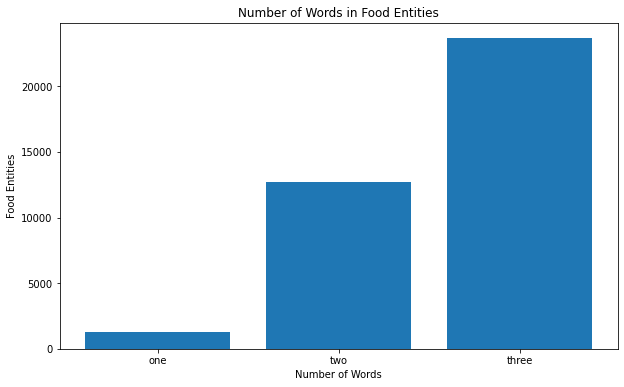

In [9]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()

In [10]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)

1-worded food entities: 1257
2-worded food entities: 838
3-worded food entities: 698


### Preparing train and test dataset

In [11]:
food_templates = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge"
]

len(food_templates)

40

In [12]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"],
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))

In [13]:
# print the number of food sentences, as well as an example sentence
for key in TRAIN_FOOD_DATA:
    print("{} {} sentences: {}".format(len(TRAIN_FOOD_DATA[key]), key, TRAIN_FOOD_DATA[key][0]))

167 one_food sentences: ('I had some griddlecake sandwiches at dinner last night', {'entities': [(11, 33, 'FOOD')]})
167 two_foods sentences: ('today I ate a mexicana galletas mixtas and a rived veggies for lunch', {'entities': [(14, 38, 'FOOD'), (45, 58, 'FOOD')]})
167 three_foods sentences: ("I've already had a bag of twists, covered raisins yogurt and brown rice loaf from the fridge", {'entities': [(26, 32, 'FOOD'), (34, 56, 'FOOD'), (61, 76, 'FOOD')]})


In [14]:
# print the number of food sentences, as well as an example sentence
for key in TEST_FOOD_DATA:
    print("{} {} sentences: {}".format(len(TEST_FOOD_DATA[key]), key, TEST_FOOD_DATA[key][0]))

881 one_food sentences: ('I had a bowl of rotini', {'entities': [(16, 22, 'FOOD')]})
151 two_foods sentences: ('I had a bowl of fontine cheese with roasted salted sunflower and I wanted to go to the mall today', {'entities': [(16, 30, 'FOOD'), (36, 60, 'FOOD')]})
202 three_foods sentences: ('I tasted some mint chocolate chunks, focaccia and dumpling at the office', {'entities': [(14, 35, 'FOOD'), (37, 45, 'FOOD'), (50, 58, 'FOOD')]})


In [15]:
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]
TEST_FOOD_DATA_COMBINED = TEST_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

#### Helper Functions

In [16]:
def create_patterns(data, type):
    patterns = []
    for item in data:
        pattern = {
                    "label": type,
                    "pattern": item
                    }
        patterns.append(pattern)
    return (patterns)

def generate_rules(nlp, patterns):
    ruler = nlp.add_pipe("entity_ruler", before="ner")
    ruler.add_patterns(patterns)
    #nlp.to_disk("model_ner")
    return nlp

def extract_entities(doc):
    for ent in doc.ents: 
        print(ent.text, ent.label_)

def test_model(doc):
    results = []
    entities = []
    for ent in doc.ents:
        entities.append((ent.start_char, ent.end_char, ent.label_))
    if len(entities) > 0:
        results = [text, {"entities": entities}]
        return (results)
    
def clean_text(text):
    cleaned = re.sub(r"[\(\[].*?[\)\]]", "", text)
    return (cleaned)

def create_training(nlp, TRAIN_DATA):
    
    db = DocBin() # create a DocBin object

    for text, annot in tqdm(TRAIN_DATA): # data in previous format
        doc = nlp.make_doc(text) # create doc object from text
        ents = []
        for start, end, label in annot["entities"]: # add character indexes
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents # label the text with the ents
        db.add(doc)
    return (db)   


### NER Model

In [17]:
# download spacy language model
# !python -m spacy download en_core_web_lg

In [18]:
# Load pre-trained nlp model
nlp = spacy.load("en_core_web_lg")

In [19]:
patterns = create_patterns(foods, "FOOD")
#print(patterns)

In [20]:
nlp = generate_rules(nlp, patterns)

In [21]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'entity_ruler',
 'ner']

In [22]:
nlp.analyze_pipes()

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False},
  'attribute_ruler': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'entity_ruler': {'assigns': ['doc.ents', 'token.ent_type', 'token.ent_iob'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False},
  'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ent

### Testing the Rules Based NER

In [23]:
text = "Bob love to eat Brown Rice Pasta"
text = text.lower()
doc = nlp(text)
extract_entities(doc)

bob PERSON
rice FOOD
pasta FOOD


In [24]:
displacy.render(doc, style="ent")

In [25]:
text = "Bob love to eat Ice Cream"
text = text.lower()
doc = nlp(text)
extract_entities(doc)

bob PERSON
ice FOOD
cream FOOD


In [26]:
displacy.render(doc, style="ent")

In [27]:
matcher = Matcher(nlp.vocab)
pattern = [{"ENT_TYPE": "FOOD", "OP": "+"}]
matcher.add("FOOD", [pattern], greedy='LONGEST')
doc = nlp(text)
matches = matcher(doc)
matches.sort(key = lambda x: x[1])
print (len(matches))
for match in matches[:10]:
    print (match, doc[match[1]:match[2]])


1
(17898275690771780158, 4, 6) ice cream


In [28]:
test_df = []
for i in range(len(TRAIN_FOOD_DATA_COMBINED)):
    test_df.append(TRAIN_FOOD_DATA_COMBINED[i][0])

test_df = pd.DataFrame({"sentences" : test_df})
test_df.head()

,sentences
0,I had some griddlecake sandwiches at dinner la...
1,I made pursuit energy for yesterday's dinner
2,When I was having lunch I ate a sandwiches
3,I just finished my crunchy coated almonds
4,I brought a basket of pizza mix for breakfast ...


In [29]:
i=0
for sentence in test_df.sentences:
    doc = nlp(sentence)
    displacy.render(doc, style="ent")
    if i==10:
        break
    i +=1


In [30]:
nlp.get_pipe("ner").labels

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'FOOD',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

### Train the model

In [31]:
TRAIN_DATA = create_training(nlp, TRAIN_FOOD_DATA_COMBINED)
TRAIN_DATA.to_disk("./train.spacy") # save the docbin object

100%|██████████| 501/501 [00:00<00:00, 655.39it/s]


In [32]:
VALID_DATA = create_training(nlp, TEST_FOOD_DATA_COMBINED)
VALID_DATA.to_disk("./valid.spacy") 

100%|██████████| 1215/1215 [00:00<00:00, 2835.17it/s]


In [33]:
!python -m spacy init fill-config base_config.cfg config.cfg

[+] Auto-filled config with all values
[+] Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [34]:
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./valid.spacy

[i] Saving to output directory: output

[2022-06-20 05:02:40,756] [INFO] Set up nlp object from config
[2022-06-20 05:02:40,766] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-06-20 05:02:40,770] [INFO] Created vocabulary
[2022-06-20 05:02:40,806] [INFO] Finished initializing nlp object
[2022-06-20 05:02:41,213] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     49.17    0.00    0.00    0.00    0.00
  3     200         62.28   1802.32   99.30   99.42   99.18    0.99
  8     400         11.40     14.39   99.50   99.53   99.48    1.00
 14     600          1.12      0.60   99.27   99.36   99.18    0.99
 21     800          7.38      7.64   99.53   99.42   99.65    1.00
 29    1000         41.82     18.35   99.36   99.24   99.48    0.99
 40    1200         11.51      4.78   99.48   99.36   99.59    0.99
 53    1400          0.00      0.00   99.42   99.30   99.53    0.99
 69    1600         80.06     27.68   99.53   99.42   99.65

In [35]:
nlp_best = spacy.load("output/model-best")

#### We can recognize existing entities with the custom FOOD entities using different annotation tool.  

In [36]:
nlp_best.get_pipe("ner").labels

('FOOD',)

In [37]:
text = "I have to eat Pizza"
text = text.lower()
doc = nlp_best(text)
extract_entities(doc)

eat pizza FOOD


In [38]:
displacy.render(doc, style="ent")

In [39]:
i=0
for sentence in test_df.sentences:
    doc = nlp_best(sentence)
    displacy.render(doc, style="ent")
    if i==10:
        break
    i +=1